# Pytorch_lightning_audio

In [1]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

In [2]:
from tqdm.notebook import tqdm 
import librosa
import numpy as np
import scipy.signal
from IPython.display import display, Audio
from matplotlib import pyplot as plt
import sys
import glob

from numba import jit

from scipy.signal import stft,istft,convolve

data_path = "datasets/data"
label_path = "datasets/label"
audio = "datasets/data/0noise.wav"

In [4]:
#audio
sample_rate = 8000
slice_size = 2 ** 15


#stft
hann_window = 512
DFT_size = 512
time_shift = 256

        
def makePSM(addnoise,clean):
    X, S = addnoise, clean #観測信号、所望信号stft型
    A = (np.abs(S) / np.abs(X)) * np.cos((np.angle(S)-np.angle(X)))
    B = np.maximum(A,0)
    G = np.minimum(B,1)
    return G

def wavLoader(data_path,label_path):
    print("Loading...data:",data_path,"label:",label_path)
    data_files = glob.glob(data_path+"/*.wav")
    label_files = glob.glob(label_path+"/*.wav")
     
    data_list = []
    
    for i in tqdm(range(len(data_files))):
        data, _ = librosa.load(data_files[i],sr=sample_rate)
        label, _ = librosa.load(label_files[i],sr=sample_rate)
        
        q, mod = divmod(len(data), slice_size)
        usedata = data[:-mod]
        uselabel = label[:-mod]
        
        for e in range(q):
            slice_data = usedata[e:e * slice_size]
            slice_label = uselabel[e:e * slice_size]
            # STFT
            _,_,stft_data = stft(slice_data,fs=sample_rate,window="hann",nperseg=hann_window, noverlap=time_shift)
            _,_,stft_label = stft(slice_label,fs=sample_rate,window="hann",nperseg=hann_window, noverlap=time_shift)
            # make PSM
            stft_label = makePSM(stft_data,stft_label)
            # numpy to torch
            stft_data = torch.from_numpy(stft_data.astype(np.float32)).clone()
            stft_label = torch.from_numpy(stft_label.astype(np.float32)).clone()
            data_list.append([stft_data,stft_label])

    print("batch size=",q,",stft_size=",stft_data.shape)
    return data_list

In [5]:
datasets = wavLoader(data_path,label_path)

Loading...data: datasets/data label: datasets/label


C:\Users\zankyo\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\zankyo\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  



batch size= 2 ,stft_size= torch.Size([257, 129])


In [7]:
len(datasets)

31206

# ネットワークの定義
[257, 385]

In [21]:
input_size = 527*129
hidden_size = 129*129
output_size = 527*129

class LitAutoEncoder(pl.LightningModule):
    def __init__(self):# ここで計算を定義します
        super(LitAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
#             nn.Linear(hidden_size,hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size,hidden_size),
#             nn.ReLU(),
            nn.Linear(hidden_size,output_size),
            nn.Sigmoid()
        )

#         self.batch_size = batch_size
    
    def forward(self, x):# ここは推論フェーズにのみ使われます
        # Lightningではforwardは予測/推論のアクションを定義します。
        embedding = self.encoder(x)
        return embedding
    
    def configure_optimizers(self):# Optimaizerの設定
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):# 完全なトレーニングループ
        # training_stepでは訓練ループを定義していて、これはforwardとは独立しています
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)  # forwardを呼び出す self(x) でもよい
        loss = F.mse_loss(z, x)
        self.log("train_loss", loss)
        return loss
    # lossを返している限りはLightningによって自動で最適化される（backward、optimizerの更新）

    def validation_step(self, val_batch, batch_idx):#完全な検証ループ
        # 検証ステップ
        x, y = val_batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        loss = F.mse_loss(z, x)
        self.log("val_loss", loss)
        return loss

In [24]:
# train : val = 80% : 20%
n_train = int(len(datasets) * 0.8)
n_val = len(datasets) - n_train
train, val = random_split(datasets, [n_train, n_val])

#モデルの呼び出しと初期化
autoencoder = LitAutoEncoder()# 学習モデルのインスタンス化
#トレーニング開始
trainer = pl.Trainer(max_epochs=100, gpus=1)# 学習用のインスタンス化と学習の設定

trainer.fit(autoencoder, 
            DataLoader(train, batch_size = 2), 
            DataLoader(val, batch_size = 2))# 学習ループ実行
# batchサイズはdata数に対して割り切れる数を渡す
# ここでdataLoaderした訓練データと検証データをわたす。

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RuntimeError: CUDA out of memory. Tried to allocate 4.21 GiB (GPU 0; 8.00 GiB total capacity; 4.21 GiB already allocated; 1.96 GiB free; 4.22 GiB reserved in total by PyTorch)

In [99]:
def main():

    # Lord data
    
    print("Loading Cleandata")
    data_files = glob.glob(data_path+"*.wav")
    label_files = glob.glob(label_path+"*.wav")
    
    data_list = []
    label_list = []
    
    for file in tqdm(data_files):
        data, rate = librosa.load(file,sr=16000)
        
        
        data_list.append(data)
        
        
        
        
        
    print(data_files)
    
    
    
    n_sources=len(clean_wave_files)
    clean_data=[]
    n_samples=0
    
    for wave_file in tqdm(clean_wave_files):
        data, rate = librosa.load(wave_file,sr=None)
        if n_samples<len(data):
            n_samples=len(data)
        clean_data.append(data)
    print(data_files)
    
    
    n_sources=len(clean_wave_files)
    clean_data=[]
    n_samples=0
    
    for wave_file in tqdm(clean_wave_files):
        data, rate = librosa.load(wave_file,sr=None)
        if n_samples<len(data):
            n_samples=len(data)
        clean_data.append(data)
        
#     print("Loading Noisedata")
#     noise_files = glob.glob(noise_dir+"/*/*.wav")
#     noise_data=[]
#     for f in tqdm(noise_files):
#         data, rate = librosa.load(f,sr=rate)
#         noise_data.append(data)
        
#     print(n_sources," wave files")
#     print(len(noise_files)," noise files")
    
#     # zero pudding
    
#     output = np.zeros([n_sources,n_samples])
#     for i in tqdm(range(n_sources)):
#         output[i,:len(clean_data[i])] = clean_data[i]
    
#     # write wave file
#     """
#     雑音データが足りないので、雑音はランダムに選択し、SNRも0.7-1.2の間からランダムに選択してつけてる
#     """
#     for i in tqdm(range(n_sources)):
#         sf.write("label/"+str(i)+"clean.wav", output[i], rate, subtype="PCM_16")
        
#         noise_num = random.randint(0,len(noise_files)-1)
#         noise_select = noise_data[noise_num]
#         addnoisedata = addnoise(output[i],noise_select,SNR = random.uniform(0.7, 1.2))
        
#         sf.write("data/"+str(i)+"noise.wav", addnoisedata, rate, subtype="PCM_16")
        
        
main()

Loading Cleandata
['datasets/data\\0noise.wav', 'datasets/data\\10000noise.wav', 'datasets/data\\10001noise.wav', 'datasets/data\\10002noise.wav', 'datasets/data\\10003noise.wav', 'datasets/data\\10004noise.wav', 'datasets/data\\10005noise.wav', 'datasets/data\\10006noise.wav', 'datasets/data\\10007noise.wav', 'datasets/data\\10008noise.wav', 'datasets/data\\10009noise.wav', 'datasets/data\\1000noise.wav', 'datasets/data\\10010noise.wav', 'datasets/data\\10011noise.wav', 'datasets/data\\10012noise.wav', 'datasets/data\\10013noise.wav', 'datasets/data\\10014noise.wav', 'datasets/data\\10015noise.wav', 'datasets/data\\10016noise.wav', 'datasets/data\\10017noise.wav', 'datasets/data\\10018noise.wav', 'datasets/data\\10019noise.wav', 'datasets/data\\1001noise.wav', 'datasets/data\\10020noise.wav', 'datasets/data\\10021noise.wav', 'datasets/data\\10022noise.wav', 'datasets/data\\10023noise.wav', 'datasets/data\\10024noise.wav', 'datasets/data\\10025noise.wav', 'datasets/data\\10026noise.wav

In [10]:
data, fs = librosa.load(audio,sr=16000)

In [45]:
display(Audio(data,rate=16000))

(512,)


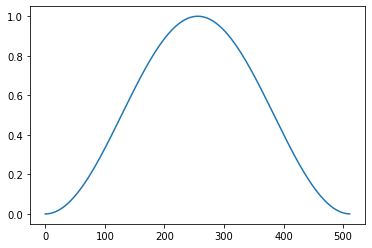

In [46]:
def hannWin(N):
    window = 0.5 + 0.5*np.cos(2*np.pi*( np.arange(-N/2,N/2)+np.remainder(N,2)/2 ) / N);
    return window

print(hannWin(512).shape)

plt.plot(hannWin(512))

In [11]:
w=2**15
print("音声切り出し長さ",w,"タップ、時間にして",w/fs,"s")
print("sampling rate", fs)
q, mod = divmod(len(data), w)
print("data length",len(data),"に対して、mini batch size",q,", あまり",mod)

usedata = data[:-mod]
print("あまり分を除去して",len(usedata))

音声切り出し長さ 32768 タップ、時間にして 2.048 s
sampling rate 16000
data length 155040 に対して、mini batch size 4 , あまり 23968
あまり分を除去して 131072


In [16]:
f,t,stft_data = stft(usedata[:w],fs=fs,window="hann",nperseg=2**10,noverlap=None)
print(data.shape)
print(stft_data.shape)
print("time",t.shape,"freq",f.shape)

(155040,)
(513, 65)
time (65,) freq (513,)


In [105]:
a = np.arange(24)
print(a)

a_4_6 = np.reshape(a,[4, 6])
print(a_4_6)

a1 = np.reshape(a_4_6,[1,24])
print(a1)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]]
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]]
